In [4]:
from stock_data_ingestion import ingest_stocks_to_df
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display 
from keras.layers import LSTM, Dense, Input, Dropout, Activation, BatchNormalization, LayerNormalization, GRU, Bidirectional
from keras import Sequential
from sklearn.model_selection import TimeSeriesSplit
from keras.optimizers import Adam, SGD
from keras.losses import MeanSquaredError
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from keras.activations import relu
from keras.callbacks import EarlyStopping
from preprocessing_ts_keras_finance import to_ts_data

## Data Preprocessing

,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2015-03-02,5.770000,5.680000,5.700000,5.770000,8400.0,5.770000,GSIT
2015-03-03,5.800000,5.750000,5.750000,5.800000,20300.0,5.800000,GSIT
2015-03-04,5.800000,5.700000,5.780000,5.760000,24300.0,5.760000,GSIT
2015-03-05,5.850000,5.790000,5.790000,5.840000,15900.0,5.840000,GSIT
2015-03-06,5.850000,5.580000,5.850000,5.830000,19200.0,5.830000,GSIT
...,...,...,...,...,...,...,...
2021-02-22,182.440002,175.059998,181.000000,175.289993,2661300.0,175.289993,ARKW
2021-02-23,170.748993,156.880005,165.570007,170.160004,6246800.0,170.160004,ARKW
2021-02-24,171.776001,165.910004,169.100006,170.539993,2394900.0,170.539993,ARKW


GSIT len 1510
ICAD len 1510
XAIR len 683
LTRN len 180
ARKK len 1510
ARKF len 521
ARKW len 1510


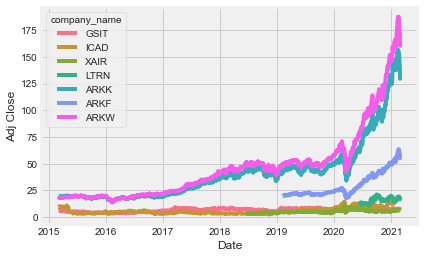

In [5]:
# comment first line out after first use to prevent 
# giving the source website for the stocks too much traffic. 
stocks_df = ingest_stocks_to_df()
stock_list = stocks_df.company_name.unique()
# displays
display(stocks_df)
for stock in stock_list:
    print(stock, 'len', len(stocks_df[stocks_df.company_name == stock].index))
sns.lineplot(x=stocks_df.index, y='Adj Close',data=stocks_df, legend='auto', hue='company_name')
plt.show()
data_gen_train, data_gen_test = to_ts_data(stock_list[0], stocks_df) 

## Model Building

In [22]:
def lstm_model(nodes_lstm=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    lstm_layer = LSTM(nodes_lstm, recurrent_dropout=recurrent_dropout)
    model = Sequential()
#     model.add(Input((1,1)))
    model.add(lstm_layer)
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
def seq_lstm_model(nodes_lstm=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    lstm_layer = LSTM(nodes_lstm, recurrent_dropout=recurrent_dropout, return_sequences=True)
    model = Sequential()
    model.add(lstm_layer)
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
def bi_seq_lstm_model(nodes_lstm=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    lstm_layer = LSTM(nodes_lstm, recurrent_dropout=recurrent_dropout, return_sequences=True)
    model = Sequential()
    model.add(Bidirectional(lstm_layer))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
def stack_lstm_model(nodes_lstm=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    lstm_layer = LSTM(nodes_lstm, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True)
    model = Sequential()
    model.add(lstm_layer)
    model.add(lstm_layer)
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
def bi_stack_lstm_model(nodes_lstm=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    lstm_layer = LSTM(nodes_lstm, recurrent_dropout=recurrent_dropout, return_sequences=True)
    model = Sequential()
    model.add(Bidirectional(lstm_layer))
    model.add(Bidirectional(lstm_layer))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
def bi_back_lstm_model(nodes_lstm=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    lstm_layer = LSTM(nodes_lstm, recurrent_dropout=recurrent_dropout, return_sequences=True)
    model = Sequential()
    forward_layer = LSTM(nodes_lstm, return_sequences=True)
    backward_layer = LSTM(nodes_lstm, return_sequences=True,
                       go_backwards=True)
    model.add(Bidirectional(forward_layer, backward_layer=backward_layer))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
def bi_back_stack_lstm_model(nodes_lstm=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    ## TODO: figure out how to have first bi pass sequence to second. 
    model = Sequential()
    forward_layer = LSTM(nodes_lstm, return_sequences=True)
    backward_layer = LSTM(nodes_lstm, return_sequences=True, go_backwards=True)
    model.add(Bidirectional(forward_layer, backward_layer=backward_layer, return_sequences=True))
    model.add(Bidirectional(forward_layer, backward_layer=backward_layer))

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
def stack_3_lstm_model(nodes_lstm=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    lstm_layer = LSTM(nodes_lstm, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True)
    model = Sequential()
    model.add(lstm_layer)
    model.add(lstm_layer)
    model.add(lstm_layer)
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
def deep_lstm_model(nodes_lstm=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    lstm_layer = LSTM(nodes_lstm, recurrent_dropout=recurrent_dropout)
    model = Sequential()
#     model.add(Input((1,1)))
    model.add(lstm_layer)
    model.add(Dense(32))    
    model.add(Dropout(0.5))
    model.add(Activation(relu))
    model.add(Dense(32))    
    model.add(Dropout(0.5))
    model.add(Activation(relu))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
def deep_lstm_model(nodes_lstm=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    lstm_layer = LSTM(nodes_lstm, recurrent_dropout=recurrent_dropout)
    model = Sequential()
#     model.add(Input((1,1)))
    model.add(lstm_layer)
#     model.add(Dropout(0.5))
    model.add(Dense(32))    
    model.add(Dropout(0.5))
    model.add(Activation(relu))
    model.add(Dense(32))    
    model.add(Dropout(0.5))
    model.add(Activation(relu))
    model.add(Dense(32))    
    model.add(Dropout(0.5))
    model.add(Activation(relu))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
def lstm_dense_model(nodes_lstm=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    lstm_layer = LSTM(nodes_lstm, dropout=dropout, recurrent_dropout=recurrent_dropout)
    model = Sequential()
#     model.add(Input((1,1)))
    model.add(lstm_layer)
    model.add(Dense(32))
    model.add(Activation(relu))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
def batch_norm_lstm_model(nodes_lstm=50, dropout=0.5, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    lstm_layer = LSTM(nodes_lstm, recurrent_dropout=recurrent_dropout)
    model = Sequential()
#     model.add(Input((1,1)))
    model.add(lstm_layer)
    model.add(BatchNormalization())
    model.add(Dense(32))    
    model.add(BatchNormalization())
    model.add(Activation(relu))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
def layer_norm_lstm_model(nodes_lstm=50, dropout=0.5, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    lstm_layer = LSTM(nodes_lstm, recurrent_dropout=recurrent_dropout)
    model = Sequential()
#     model.add(Input((1,1)))
    model.add(lstm_layer)
    model.add(LayerNormalization())
    model.add(Dense(32))    
    model.add(LayerNormalization())
    model.add(Activation(relu))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
# lstm_model().summary()
def batch_norm_drop_lstm_model(nodes_lstm=50, dropout=0.5, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    lstm_layer = LSTM(nodes_lstm, recurrent_dropout=recurrent_dropout)
    model = Sequential()
#     model.add(Input((1,1)))
    model.add(lstm_layer)
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(32))    
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Activation(relu))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model
def gru_model(nodes=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
    model = Sequential()
    model.add(GRU(nodes))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)
    return model

## model evaluation

In [7]:
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [8]:
model = lstm_model()
model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
model.summary()
model.evaluate(data_gen_test)

Epoch 1/100
9/9 [==============================] - 3s 58ms/step - loss: 25.6235 - mse: 25.6235
Epoch 2/100
9/9 [==============================] - 0s 51ms/step - loss: 3.7571 - mse: 3.7571
Epoch 3/100
9/9 [==============================] - 1s 61ms/step - loss: 2.8620 - mse: 2.8620
Epoch 4/100
9/9 [==============================] - 1s 58ms/step - loss: 3.4331 - mse: 3.4331
Epoch 5/100
9/9 [==============================] - 1s 81ms/step - loss: 2.9243 - mse: 2.9243
Epoch 6/100
9/9 [==============================] - 1s 65ms/step - loss: 2.7094 - mse: 2.7094
Epoch 7/100
9/9 [==============================] - 1s 88ms/step - loss: 2.9750 - mse: 2.9750
Epoch 8/100
9/9 [==============================] - 1s 88ms/step - loss: 3.2854 - mse: 3.2854
Epoch 9/100
9/9 [==============================] - 1s 86ms/step - loss: 2.6005 - mse: 2.6005
Epoch 10/100
9/9 [==============================] - 1s 93ms/step - loss: 2.3208 - mse: 2.3208
Epoch 11/100
9/9 [==============================] - 1s 89ms/step - 

[0.5875466465950012, 0.5875466465950012]

In [9]:
model = seq_lstm_model()
model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
model.summary()
model.evaluate(data_gen_test)

Epoch 1/100
9/9 [==============================] - 3s 58ms/step - loss: 20.2998 - mse: 20.2998
Epoch 2/100
9/9 [==============================] - 1s 57ms/step - loss: 3.5877 - mse: 3.5877
Epoch 3/100
9/9 [==============================] - 1s 63ms/step - loss: 3.0653 - mse: 3.0653
Epoch 4/100
9/9 [==============================] - 0s 48ms/step - loss: 4.1344 - mse: 4.1344
Epoch 5/100
9/9 [==============================] - 0s 49ms/step - loss: 3.3311 - mse: 3.3311
Epoch 6/100
9/9 [==============================] - 0s 49ms/step - loss: 1.9100 - mse: 1.9100
Epoch 7/100
9/9 [==============================] - 0s 50ms/step - loss: 2.9188 - mse: 2.9188
Epoch 8/100
9/9 [==============================] - 0s 50ms/step - loss: 2.9556 - mse: 2.9556
Epoch 9/100
9/9 [==============================] - 0s 48ms/step - loss: 2.9374 - mse: 2.9374
Epoch 10/100
9/9 [==============================] - 0s 46ms/step - loss: 3.1937 - mse: 3.1937
Epoch 11/100
9/9 [==============================] - 1s 54ms/step - 

[0.5916388630867004, 0.5916388630867004]

In [10]:
## bi is worse than normal performance
model = bi_seq_lstm_model()
model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
model.summary()
model.evaluate(data_gen_test)

Epoch 1/100
9/9 [==============================] - 4s 75ms/step - loss: 20.3353 - mse: 20.3353
Epoch 2/100
9/9 [==============================] - 1s 74ms/step - loss: 2.3442 - mse: 2.3442
Epoch 3/100
9/9 [==============================] - 1s 76ms/step - loss: 2.5781 - mse: 2.5781
Epoch 4/100
9/9 [==============================] - 1s 77ms/step - loss: 2.9411 - mse: 2.9411
Epoch 5/100
9/9 [==============================] - 1s 76ms/step - loss: 2.9050 - mse: 2.9050
Epoch 6/100
9/9 [==============================] - 1s 76ms/step - loss: 2.9424 - mse: 2.9424
Epoch 7/100
9/9 [==============================] - 1s 75ms/step - loss: 3.7134 - mse: 3.7134
Epoch 8/100
9/9 [==============================] - 1s 77ms/step - loss: 3.8270 - mse: 3.8270
Epoch 9/100
9/9 [==============================] - 1s 77ms/step - loss: 2.9756 - mse: 2.9756
Epoch 10/100
9/9 [==============================] - 1s 84ms/step - loss: 2.8813 - mse: 2.8813
Epoch 11/100
9/9 [==============================] - 1s 73ms/step - 

[0.7313611507415771, 0.7313611507415771]

In [11]:
model = stack_lstm_model()
model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
model.summary()
model.evaluate(data_gen_test)

Epoch 1/100
9/9 [==============================] - 3s 49ms/step - loss: 18.6518 - mse: 18.6518
Epoch 2/100
9/9 [==============================] - 0s 49ms/step - loss: 3.3098 - mse: 3.3098
Epoch 3/100
9/9 [==============================] - 0s 47ms/step - loss: 3.1020 - mse: 3.1020
Epoch 4/100
9/9 [==============================] - 0s 50ms/step - loss: 3.3478 - mse: 3.3478
Epoch 5/100
9/9 [==============================] - 0s 47ms/step - loss: 2.8998 - mse: 2.8998
Epoch 6/100
9/9 [==============================] - 0s 50ms/step - loss: 2.0524 - mse: 2.0524
Epoch 7/100
9/9 [==============================] - 0s 50ms/step - loss: 2.4135 - mse: 2.4135
Epoch 8/100
9/9 [==============================] - 0s 48ms/step - loss: 2.5419 - mse: 2.5419
Epoch 9/100
9/9 [==============================] - 0s 47ms/step - loss: 2.0306 - mse: 2.0306
Epoch 10/100
9/9 [==============================] - 0s 51ms/step - loss: 3.5899 - mse: 3.5899
Epoch 11/100
9/9 [==============================] - 0s 49ms/step - 

[0.6482141613960266, 0.6482141613960266]

In [12]:
model = bi_stack_lstm_model()
model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
model.summary()
model.evaluate(data_gen_test)

Epoch 1/100
9/9 [==============================] - 12s 181ms/step - loss: 19.3969 - mse: 19.3969
Epoch 2/100
9/9 [==============================] - 2s 166ms/step - loss: 3.0059 - mse: 3.0059
Epoch 3/100
9/9 [==============================] - 2s 172ms/step - loss: 2.4847 - mse: 2.4847
Epoch 4/100
9/9 [==============================] - 2s 180ms/step - loss: 3.3939 - mse: 3.3939
Epoch 5/100
9/9 [==============================] - 2s 173ms/step - loss: 3.0596 - mse: 3.0596
Epoch 6/100
9/9 [==============================] - 2s 170ms/step - loss: 3.8863 - mse: 3.8863
Epoch 7/100
9/9 [==============================] - 2s 181ms/step - loss: 3.0822 - mse: 3.0822
Epoch 8/100
9/9 [==============================] - 2s 237ms/step - loss: 2.8699 - mse: 2.8699
Epoch 9/100
9/9 [==============================] - 2s 266ms/step - loss: 2.6428 - mse: 2.6428
Epoch 10/100
9/9 [==============================] - 2s 247ms/step - loss: 2.3296 - mse: 2.3296
Epoch 11/100
9/9 [==============================] - 2s 2

[0.4936085641384125, 0.4936085641384125]

In [13]:
model = bi_back_lstm_model()
model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
model.summary()
model.evaluate(data_gen_test)

Epoch 1/100
9/9 [==============================] - 5s 67ms/step - loss: 22.1451 - mse: 22.1451
Epoch 2/100
9/9 [==============================] - 1s 64ms/step - loss: 2.8938 - mse: 2.8938
Epoch 3/100
9/9 [==============================] - 1s 70ms/step - loss: 2.1290 - mse: 2.1290
Epoch 4/100
9/9 [==============================] - 1s 69ms/step - loss: 2.7939 - mse: 2.7939
Epoch 5/100
9/9 [==============================] - 1s 68ms/step - loss: 3.3690 - mse: 3.3690
Epoch 6/100
9/9 [==============================] - 1s 67ms/step - loss: 2.6608 - mse: 2.6608
Epoch 7/100
9/9 [==============================] - 1s 72ms/step - loss: 2.5488 - mse: 2.5488
Epoch 8/100
9/9 [==============================] - 1s 89ms/step - loss: 2.1268 - mse: 2.1268
Epoch 9/100
9/9 [==============================] - 1s 116ms/step - loss: 2.7385 - mse: 2.7385
Epoch 10/100
9/9 [==============================] - 1s 109ms/step - loss: 2.5151 - mse: 2.5151
Epoch 11/100
9/9 [==============================] - 1s 95ms/step 

[0.5262715220451355, 0.5262715220451355]

In [14]:
## needs to pass a sequence from first bi to second
# model = bi_back_stack_lstm_model()
# model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
# model.summary()
# model.evaluate(data_gen_test)

In [15]:
model = stack_3_lstm_model()
model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
model.summary()
model.evaluate(data_gen_test)

Epoch 1/100
9/9 [==============================] - 3s 71ms/step - loss: 21.8044 - mse: 21.8044
Epoch 2/100
9/9 [==============================] - 1s 51ms/step - loss: 3.6990 - mse: 3.6990
Epoch 3/100
9/9 [==============================] - 0s 50ms/step - loss: 4.1096 - mse: 4.1096
Epoch 4/100
9/9 [==============================] - 0s 45ms/step - loss: 1.7513 - mse: 1.7513
Epoch 5/100
9/9 [==============================] - 0s 42ms/step - loss: 2.1134 - mse: 2.1134
Epoch 6/100
9/9 [==============================] - 0s 51ms/step - loss: 2.3779 - mse: 2.3779
Epoch 7/100
9/9 [==============================] - 0s 48ms/step - loss: 2.2897 - mse: 2.2897
Epoch 8/100
9/9 [==============================] - 0s 49ms/step - loss: 1.9715 - mse: 1.9715
Epoch 9/100
9/9 [==============================] - 0s 41ms/step - loss: 2.1338 - mse: 2.1338
Epoch 10/100
9/9 [==============================] - 0s 44ms/step - loss: 2.8771 - mse: 2.8771
Epoch 11/100
9/9 [==============================] - 0s 48ms/step - 

[0.5583867430686951, 0.5583867430686951]

In [16]:
model = deep_lstm_model()
model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
model.summary()
model.evaluate(data_gen_test)

Epoch 1/100
9/9 [==============================] - 3s 53ms/step - loss: 21.9634 - mse: 21.9634
Epoch 2/100
9/9 [==============================] - 1s 60ms/step - loss: 11.4250 - mse: 11.4250
Epoch 3/100
9/9 [==============================] - 1s 55ms/step - loss: 9.5048 - mse: 9.5048
Epoch 4/100
9/9 [==============================] - 1s 71ms/step - loss: 9.9796 - mse: 9.9796
Epoch 5/100
9/9 [==============================] - 1s 59ms/step - loss: 7.5560 - mse: 7.5560
Epoch 6/100
9/9 [==============================] - 0s 47ms/step - loss: 7.8222 - mse: 7.8222
Epoch 7/100
9/9 [==============================] - 0s 48ms/step - loss: 7.9343 - mse: 7.9343
Epoch 8/100
9/9 [==============================] - 1s 60ms/step - loss: 7.6211 - mse: 7.6211
Epoch 9/100
9/9 [==============================] - 0s 48ms/step - loss: 6.4610 - mse: 6.4610
Epoch 10/100
9/9 [==============================] - 0s 54ms/step - loss: 7.2251 - mse: 7.2251
Epoch 11/100
9/9 [==============================] - 0s 43ms/step 

[0.7875046730041504, 0.7875046730041504]

In [17]:
model = lstm_dense_model()
model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
model.summary()
model.evaluate(data_gen_test)

Epoch 1/100
9/9 [==============================] - 3s 46ms/step - loss: 38.2980 - mse: 38.2980
Epoch 2/100
9/9 [==============================] - 0s 42ms/step - loss: 5.6113 - mse: 5.6113
Epoch 3/100
9/9 [==============================] - 0s 45ms/step - loss: 2.2700 - mse: 2.2700
Epoch 4/100
9/9 [==============================] - 0s 46ms/step - loss: 3.7361 - mse: 3.7361
Epoch 5/100
9/9 [==============================] - 0s 47ms/step - loss: 2.6994 - mse: 2.6994
Epoch 6/100
9/9 [==============================] - 0s 44ms/step - loss: 2.8685 - mse: 2.8685
Epoch 7/100
9/9 [==============================] - 0s 41ms/step - loss: 2.7528 - mse: 2.7528
Epoch 8/100
9/9 [==============================] - 0s 45ms/step - loss: 3.0685 - mse: 3.0685
Epoch 9/100
9/9 [==============================] - 0s 45ms/step - loss: 3.4771 - mse: 3.4771
Epoch 10/100
9/9 [==============================] - 0s 54ms/step - loss: 2.6080 - mse: 2.6080
Epoch 11/100
9/9 [==============================] - 0s 40ms/step - 

[0.4827669858932495, 0.4827669858932495]

In [18]:
model = batch_norm_lstm_model()
model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
model.summary()
model.evaluate(data_gen_test)

Epoch 1/100
9/9 [==============================] - 4s 51ms/step - loss: 48.9082 - mse: 48.9082
Epoch 2/100
9/9 [==============================] - 0s 47ms/step - loss: 27.3246 - mse: 27.3246
Epoch 3/100
9/9 [==============================] - 0s 42ms/step - loss: 16.2593 - mse: 16.2593
Epoch 4/100
9/9 [==============================] - 1s 70ms/step - loss: 10.1265 - mse: 10.1265
Epoch 5/100
9/9 [==============================] - 1s 65ms/step - loss: 6.8159 - mse: 6.8159
Epoch 6/100
9/9 [==============================] - 0s 46ms/step - loss: 7.9272 - mse: 7.9272
Epoch 7/100
9/9 [==============================] - 0s 54ms/step - loss: 6.8193 - mse: 6.8193
Epoch 8/100
9/9 [==============================] - 0s 46ms/step - loss: 8.8974 - mse: 8.8974
Epoch 9/100
9/9 [==============================] - 0s 50ms/step - loss: 6.8820 - mse: 6.8820
Epoch 10/100
9/9 [==============================] - 1s 75ms/step - loss: 6.4671 - mse: 6.4671
Epoch 11/100
9/9 [==============================] - 1s 59ms/s

[1.723872184753418, 1.723872184753418]

In [23]:
model = layer_norm_lstm_model()
model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
model.summary()
model.evaluate(data_gen_test)

Epoch 1/100
9/9 [==============================] - 4s 79ms/step - loss: 10.3177 - mse: 10.3177
Epoch 2/100
9/9 [==============================] - 0s 50ms/step - loss: 2.8220 - mse: 2.8220
Epoch 3/100
9/9 [==============================] - 1s 81ms/step - loss: 2.4047 - mse: 2.4047
Epoch 4/100
9/9 [==============================] - 1s 69ms/step - loss: 1.6170 - mse: 1.6170
Epoch 5/100
9/9 [==============================] - 1s 56ms/step - loss: 2.8918 - mse: 2.8918
Epoch 6/100
9/9 [==============================] - 1s 64ms/step - loss: 3.1977 - mse: 3.1977
Epoch 7/100
9/9 [==============================] - 1s 58ms/step - loss: 2.9403 - mse: 2.9403
Epoch 8/100
9/9 [==============================] - 1s 59ms/step - loss: 2.1939 - mse: 2.1939
Epoch 9/100
9/9 [==============================] - 1s 58ms/step - loss: 2.0440 - mse: 2.0440
Epoch 10/100
9/9 [==============================] - 1s 56ms/step - loss: 2.4830 - mse: 2.4830
Epoch 11/100
9/9 [==============================] - 1s 56ms/step - 

[0.6985833048820496, 0.6985833048820496]

In [20]:
## much better with drop out than without. 
model = batch_norm_drop_lstm_model()
model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
model.summary()
model.evaluate(data_gen_test)

Epoch 1/100
9/9 [==============================] - 4s 71ms/step - loss: 33.0832 - mse: 33.0832
Epoch 2/100
9/9 [==============================] - 1s 69ms/step - loss: 23.9075 - mse: 23.9075
Epoch 3/100
9/9 [==============================] - 1s 66ms/step - loss: 17.3381 - mse: 17.3381
Epoch 4/100
9/9 [==============================] - 1s 58ms/step - loss: 10.6094 - mse: 10.6094
Epoch 5/100
9/9 [==============================] - 1s 71ms/step - loss: 7.7551 - mse: 7.7551
Epoch 6/100
9/9 [==============================] - 1s 66ms/step - loss: 7.3762 - mse: 7.3762
Epoch 7/100
9/9 [==============================] - 1s 62ms/step - loss: 7.0882 - mse: 7.0882
Epoch 8/100
9/9 [==============================] - 1s 55ms/step - loss: 7.5270 - mse: 7.5270
Epoch 9/100
9/9 [==============================] - 1s 66ms/step - loss: 7.3039 - mse: 7.3039
Epoch 10/100
9/9 [==============================] - 1s 81ms/step - loss: 6.7746 - mse: 6.7746
Epoch 11/100
9/9 [==============================] - 1s 89ms/s

9/9 [==============================] - 1s 57ms/step - loss: 3.2458 - mse: 3.2458
Epoch 89/100
9/9 [==============================] - 0s 52ms/step - loss: 4.4798 - mse: 4.4798
Epoch 90/100
9/9 [==============================] - 0s 53ms/step - loss: 4.5000 - mse: 4.5000
Epoch 91/100
9/9 [==============================] - 0s 50ms/step - loss: 4.1194 - mse: 4.1194
Epoch 92/100
9/9 [==============================] - 1s 61ms/step - loss: 3.6880 - mse: 3.6880
Epoch 93/100
9/9 [==============================] - 1s 58ms/step - loss: 3.9143 - mse: 3.9143
Epoch 94/100
9/9 [==============================] - 1s 55ms/step - loss: 3.7892 - mse: 3.7892
Epoch 95/100
9/9 [==============================] - 0s 50ms/step - loss: 4.5635 - mse: 4.5635
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50)                22200     
________________________________________

[3.054544448852539, 3.054544448852539]

In [21]:
model = gru_model()
model.fit(data_gen_train, epochs=100, callbacks=[early_stop])
model.summary()
model.evaluate(data_gen_test)

Epoch 1/100
9/9 [==============================] - 4s 44ms/step - loss: 4.8552 - mse: 4.8552
Epoch 2/100
9/9 [==============================] - 0s 51ms/step - loss: 5.0709 - mse: 5.0709
Epoch 3/100
9/9 [==============================] - 0s 40ms/step - loss: 3.0959 - mse: 3.0959
Epoch 4/100
9/9 [==============================] - 1s 62ms/step - loss: 2.9718 - mse: 2.9718
Epoch 5/100
9/9 [==============================] - 0s 45ms/step - loss: 2.0556 - mse: 2.0556
Epoch 6/100
9/9 [==============================] - 0s 45ms/step - loss: 2.4908 - mse: 2.4908
Epoch 7/100
9/9 [==============================] - 0s 49ms/step - loss: 3.4216 - mse: 3.4216
Epoch 8/100
9/9 [==============================] - 0s 50ms/step - loss: 2.5504 - mse: 2.5504
Epoch 9/100
9/9 [==============================] - 0s 46ms/step - loss: 2.5444 - mse: 2.5444
Epoch 10/100
9/9 [==============================] - 0s 45ms/step - loss: 3.3805 - mse: 3.3805
Epoch 11/100
9/9 [==============================] - 0s 45ms/step - lo

[0.5255981087684631, 0.5255981087684631]